In [ ]:
!pip3 install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 23.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=82e27c556d3c347aac293e64e0f2f2c78714ecb9b67e2c8a019c9f38284b6881
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
import pandas as pd

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as keras
#from tensorflow import keras
import cv2
from tensorflow.keras import backend as K

# for path related functionalities
import os
# for array operations
import numpy as np
# tensorflow framework
import tensorflow as tf
# keras API for deep learning
from tensorflow import keras
# for image visulaizations
import matplotlib.pyplot as plt
# for viewing iteration status
from tqdm import tqdm
import wandb
import random
from IPython.display import clear_output

import numpy as np
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn
from sklearn.cluster import KMeans
from tensorflow.keras.layers import *
from tensorflow.keras import models
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications import ResNet50
import glob2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import MeanIoU

# CONSTANT

In [1]:
!pip install -q kaggle
import os
user = 'hyeongihong' # Your user
key = '*' # Your key

if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json


In [4]:
!kaggle competitions download -c bkai-igh-neopolyp

 99% 310M/314M [00:05<00:00, 34.6MB/s]
100% 314M/314M [00:05<00:00, 61.7MB/s]


In [ ]:
!unzip /content/bkai-igh-neopolyp.zip

Archive:  /content/bkai-igh-neopolyp.zip
  inflating: sample_submission.csv   
  inflating: test/test/019410b1fcf0625f608b4ce97629ab55.jpeg  
  inflating: test/test/02fa602bb3c7abacdbd7e6afd56ea7bc.jpeg  
  inflating: test/test/0398846f67b5df7cdf3f33c3ca4d5060.jpeg  
  inflating: test/test/05734fbeedd0f9da760db74a29abdb04.jpeg  
  inflating: test/test/05b78a91391adc0bb223c4eaf3372eae.jpeg  
  inflating: test/test/0619ebebe9e9c9d00a4262b4fe4a5a95.jpeg  
  inflating: test/test/0626ab4ec3d46e602b296cc5cfd263f1.jpeg  
  inflating: test/test/0a0317371a966bf4b3466463a3c64db1.jpeg  
  inflating: test/test/0a5f3601ad4f13ccf1f4b331a412fc44.jpeg  
  inflating: test/test/0af3feff05dec1eb3a70b145a7d8d3b6.jpeg  
  inflating: test/test/0fca6a4248a41e8db8b4ed633b456aaa.jpeg  
  inflating: test/test/1002ec4a1fe748f3085f1ce88cbdf366.jpeg  
  inflating: test/test/1209db6dcdda5cc8a788edaeb6aa460a.jpeg  
  inflating: test/test/13dd311a65d2b46d0a6085835c525af6.jpeg  
  inflating: test/test/1531871f2fd85a04

In [ ]:
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256

TRAIN_DIR = '/content/train/train'
TRAIN_MASK_DIR = '/content/train_gt/train_gt'
TEST_DIR = '/content/test/test'

N_CLASS = 3

BATCH_SIZE = 32
NUM_EPOCHS = 100
NUM_WORKERS = 4
LEARNING_RATE = 0.0001 # 1e - 4

BUFF_SIZE = 1000

TRAIN_STEPS = 800//BATCH_SIZE
VALIDATION_STEPS = 200//BATCH_SIZE

# GET IMAGE

## Get path

In [ ]:
# a list to collect paths of 1000 images
image_path = []
for root, dirs, files in os.walk(TRAIN_DIR):
    # iterate over 1000 images
    for file in files:
        # create path
        path = os.path.join(root,file)
        # add path to list
        image_path.append(path)
len(image_path)

1000

In [ ]:
# a list to collect paths of 1000 masks
mask_path = []
for root, dirs, files in os.walk(TRAIN_MASK_DIR):
    #iterate over 1000 masks
    for file in files:
        # obtain the path
        path = os.path.join(root,file)
        # add path to the list
        mask_path.append(path)
len(mask_path)

1000

## Get list images - chanel = 3

In [ ]:
def read_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
    image = image/255.0
    image = image.astype(np.float32)
    return image

(256, 256, 3)

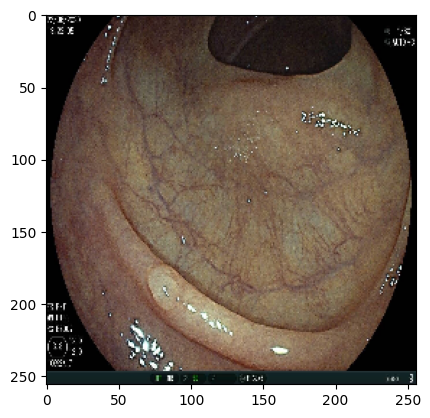

In [ ]:
plt.imshow(read_image(image_path[0]))
read_image(image_path[0]).shape

# Get list mask - chanel = 1

In [ ]:
def read_mask(mask_path):
    image = cv2.imread(mask_path)
    image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # lower boundary RED color range values; Hue (0 - 10)
    lower1 = np.array([0, 100, 20])
    upper1 = np.array([10, 255, 255])
    # upper boundary RED color range values; Hue (160 - 180)
    lower2 = np.array([160,100,20])
    upper2 = np.array([179,255,255])
    lower_mask = cv2.inRange(image, lower1, upper1)
    upper_mask = cv2.inRange(image, lower2, upper2)

    red_mask = lower_mask + upper_mask;
    red_mask[red_mask != 0] = 2

    # boundary GREEN color range values; Hue (36 - 70)
    green_mask = cv2.inRange(image, (36, 25, 25), (70, 255,255))
    green_mask[green_mask != 0] = 1

    full_mask = cv2.bitwise_or(red_mask, green_mask)
    full_mask = full_mask.astype(np.uint8)
    return full_mask

(256, 256)

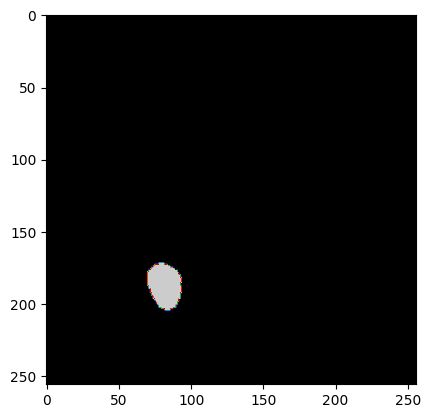

In [ ]:
plt.imshow(read_mask(mask_path[0]).astype(np.uint8), cmap='nipy_spectral')
read_mask(mask_path[0]).shape

# BUILD MODEL

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, all_filenames, input_size = (256, 256), batch_size = 32, shuffle = True, seed = 123, encode: dict = None, encode_with_kmean = None, color_mode = 'hsv', function = None) -> None:
        super(DataGenerator, self).__init__()
        assert (encode != None and encode_with_kmean == None) or (encode == None and encode_with_kmean != None), 'Not empty !'
        assert color_mode == 'hsv' or color_mode == 'rgb'
        self.all_filenames = all_filenames
        self.input_size = input_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.color_mode = color_mode
        self.encode = encode
        self.function = function
        self.kmean = encode_with_kmean
        np.random.seed(seed)
        self.on_epoch_end()
    def processing(self, mask):
        d = list(map(lambda x: self.encode[tuple(x)], mask.reshape(-1,3)))
        return np.array(d).reshape(*self.input_size, 1)
    def __len__(self):
        return int(np.floor(len(self.all_filenames) / self.batch_size))
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        all_filenames_temp = [self.all_filenames[k] for k in indexes]
        X, Y = self.__data_generation(all_filenames_temp)
        return X, Y
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.all_filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    def __data_generation(self, all_filenames_temp):
        batch = len(all_filenames_temp)
        X = np.empty(shape=(batch, *self.input_size, 3))
        Y = np.empty(shape=(batch, *self.input_size, 1))
        for i, (fn, label_fn) in enumerate(all_filenames_temp):
            # img
            img = cv2.imread(fn)
            if self.color_mode == 'hsv':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif self.color_mode == 'rgb':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = tf.image.resize(img, self.input_size, method = 'nearest')
            img = tf.cast(img, tf.float32)
            img /= 255.

            #mask
            mask = cv2.imread(label_fn, 0)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            mask = tf.image.resize(mask, self.input_size, method= 'nearest')
            mask = np.array(mask)
            if self.function:
                mask = self.function(mask)
            if self.encode:
                mask = self.processing(mask)
            if self.kmean:
                mask = self.kmean.predict(mask.reshape(-1,3)).reshape(*self.input_size, 1)
            mask = tf.cast(mask, tf.float32)
            X[i,] = img
            Y[i,] = mask
        return X, Y

In [ ]:
def encode_label(mask):
    # input (batch, rows, cols, channels)
    colors = np.unique(mask.reshape(-1,3), axis = 0)
    encoder = dict((tuple(j),i) for i,j in enumerate(colors)) # key is tuple
    _label = dict((j, list(i)) for i,j in encoder.items())
    with open('label.pickle', 'wb') as handel:
        pickle.dump(_label, handel, protocol= pickle.HIGHEST_PROTOCOL)
    return encoder
def encode_label_with_Kmeans(mask, classes):
    kmean = KMeans(classes, max_iter= 400)
    kmean.fit(mask)
    pred = kmean.predict(mask)
    classes_real =  len(set(pred))
    print(f'classes: {classes_real}')
    label = dict((j, i.tolist()) for i,j in list(zip(mask, pred))) # key is tuple
    with open('label.pickle', 'wb') as handel:
        pickle.dump(label, handel, protocol= pickle.HIGHEST_PROTOCOL)
    with open('kmean.pickle', 'wb') as handle:
        pickle.dump(kmean, handle, protocol= pickle.HIGHEST_PROTOCOL)
    return kmean
def decode_label(predict, label):
    d = list(map( lambda x: label[int(x)], predict.reshape(-1,1)))
    img =  np.array(d).reshape(predict.shape[0], predict.shape[1], 3)
    return img
def DataLoader(all_train_filename, all_mask,  all_valid_filename = None, input_size = (256,256), batch_size = 4, shuffle = True, seed = 123, color_mode = 'hsv', function = None, encode_with_kmeans = False, classes = 0) -> None:
    mask_folder = sklearn.utils.shuffle(all_mask, random_state = 47)[:16]
    mask = [tf.image.resize(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), (256,256), method = 'nearest') for img in mask_folder ]
    mask = np.array(mask)
    kmean = None
    encode = None
    if function and encode_with_kmeans == False:
        mask = function(mask)
    if encode_with_kmeans == False:
        encode = encode_label(mask)
    elif encode_with_kmeans == True:
        kmean = encode_label_with_Kmeans(mask.reshape(-1,3), classes)
    train = DataGenerator(all_train_filename, input_size, batch_size , shuffle, seed, encode, kmean, color_mode, function)
    if all_valid_filename == None:
        return train, None
    else:
        valid = DataGenerator(all_valid_filename, input_size, batch_size, shuffle, seed, encode, kmean, color_mode, function)
        return train, valid


In [ ]:
def decoder_block(x, y, filters):
    x = UpSampling2D()(x)
    x = Concatenate(axis = 3)([x,y])
    x = Conv2D(filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    return x

def resnet50_unet(input_shape, *, classes, dropout):
    """ Input """
    inputs = Input(input_shape)

    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = resnet50.get_layer("input_1").output
    s2 = resnet50.get_layer("conv1_relu").output
    s3 = resnet50.get_layer("conv2_block3_out").output
    s4 = resnet50.get_layer("conv3_block4_out").output

    x = resnet50.get_layer("conv4_block6_out").output

    """ Decoder """
    x = decoder_block(x, s4, 512)
    x = decoder_block(x, s3, 256)
    x = decoder_block(x, s2, 128)
    x = decoder_block(x, s1, 64)

    x = Dropout(dropout)(x)
    outputs = Conv2D(classes, 1, activation="softmax")(x)

    model = models.Model(inputs, outputs, name="ResNet50_U-Net")
    return model


In [ ]:
class m_iou():
    def __init__(self, classes: int) -> None:
        self.classes = classes
    def mean_iou(self,y_true, y_pred):
        y_pred = np.argmax(y_pred, axis = 3)
        miou_keras = MeanIoU(num_classes= self.classes)
        miou_keras.update_state(y_true, y_pred)
        return miou_keras.result().numpy()
    def miou_class(self, y_true, y_pred):
        y_pred = np.argmax(y_pred, axis = 3)
        miou_keras = MeanIoU(num_classes= self.classes)
        miou_keras.update_state(y_true, y_pred)
        values = np.array(miou_keras.get_weights()).reshape(self.classes, self.classes)
        for i in  range(self.classes):
            class_iou = values[i,i] / (sum(values[i,:]) + sum(values[:,i]) - values[i,i])
            print(f'IoU for class{str(i + 1)} is: {class_iou}')

In [ ]:
from tensorflow.keras import losses

In [ ]:
class DiceScoreLoss(losses.Loss):
  def call(self, y_true, y_pred, smooth):
    numerator = 2. * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return tf.reduce_mean(1 - numerator / denominator)

In [ ]:
def show_history(history, validation : bool = False):
    if validation:
        # Loss
        fig, axes = plt.subplots(figsize= (20,5))
        # Train
        axes.plot(history.epoch, history.history['loss'], color= 'r',  label = 'Train')
        axes.plot(history.epoch, history.history['val_loss'], color = 'b', label = 'Val')
        axes.set_xlabel('Epoch')
        axes.set_ylabel('Loss')
        axes.legend()
        # Acc
        fig, axes = plt.subplots(figsize= (20,5))
        # Train
        axes.plot(history.epoch, history.history['acc'], color= 'r',  label = 'Train')
        axes.plot(history.epoch, history.history['val_acc'], color = 'b', label = 'Val')
        axes.set_xlabel('Epoch')
        axes.set_ylabel('Acc')
        axes.legend()
        # Mean Iou
        fig, axes = plt.subplots(figsize= (20,5))
        # Train
        axes.plot(history.epoch, history.history['mean_iou'], color= 'r',  label = 'Train')
        axes.plot(history.epoch, history.history['val_mean_iou'], color = 'b', label = 'Val')
        axes.set_xlabel('Epoch')
        axes.set_ylabel('MeanIoU')
        axes.legend()
    else:
        fig, axes = plt.subplots(1,4, figsize= (20,5))
        # loss
        axes[0].plot(history.epoch, history.history['loss'])
        axes[0].set_title('Train')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        # Acc
        axes[1].plot(history.epoch, history.history['acc'])
        axes[1].set_title('Train')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Acc')
        # Mean Iou
        axes[2].plot(history.epoch, history.history['mean_iou'])
        axes[2].set_title('Train')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('MeanIoU')

In [ ]:
def predict(model, image_test, label, color_mode, size):
    image = cv2.imread(image_test)
    if color_mode == 'hsv':
        image_cvt = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif color_mode == 'rgb':
        image_cvt = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif color_mode == 'gray':
        image_cvt = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_cvt = tf.expand_dims(image_cvt, axis = 2)
    image_cvt = tf.image.resize(image_cvt, size, method= 'nearest')
    image_cvt = tf.cast(image_cvt, tf.float32)
    image_norm = image_cvt / 255.
    image_norm = tf.expand_dims(image_norm, axis= 0)
    new_image = model(image_norm)
    image_argmax = np.argmax(tf.squeeze(new_image, axis = 0), axis = 2)
    image_decode = decode_label(image_argmax, label)
    predict_img = tf.cast(tf.image.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), size, method = 'nearest'), tf.float32) * 0.7 + image_decode * 0.3
    return np.floor(predict_img).astype('int'), new_image

In [ ]:
def show_example(image, mask, model, label, inp_size, color_mode, function = None, kmean = None):
    img = cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB)
    img = tf.image.resize(img, inp_size, method ='nearest')
    pred, _pred= predict(model, image, label, color_mode, inp_size)
    if mask != None:
        msk= cv2.cvtColor(cv2.imread(mask), cv2.COLOR_BGR2RGB)
        msk= tf.image.resize(msk, inp_size, method = 'nearest')
        if function:
            msk = tf.convert_to_tensor(function(msk.numpy()))
        if kmean:
            y_true = kmean.predict(msk.numpy().reshape(-1,3)).reshape(*inp_size, 1)
        else:
            y_true = train_data.processing(msk.numpy())
        m.miou_class(y_true, _pred)
        y_true = decode_label(y_true, label)
        ground_truth = np.floor(img.numpy() * 0.7 + y_true * 0.3).astype('int')
        fig, axes = plt.subplots(1,3, figsize = (12,3))
        axes[0].imshow(img)
        axes[0].set_title('Original Image')
        axes[1].set_title('Ground truth')
        axes[1].imshow(ground_truth)
        axes[2].set_title('Prediction')
        axes[2].imshow(pred)

    else:
        fig, axes = plt.subplots(1,2, figsize = (12,3))
        axes[0].imshow(img)
        axes[0].set_title('Original Image')
        axes[1].set_title('Prediction')
        axes[1].imshow(pred)

In [ ]:
images = sorted(glob2.glob('/content/train/train/*.jpeg'))
masks = sorted(glob2.glob('/content/train_gt/train_gt/*.jpeg'))
data = list(zip(images, masks))
data = shuffle(data, random_state= 42)
split = int(0.9 * len(data))
all_train_filenames = data[:split]
all_valid_filenames = data[split:]

In [ ]:
train_data, valid_data = DataLoader(all_train_filenames, masks, all_valid_filenames, (256, 256), 8, True, 47, 'rgb', None, True, 2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


classes: 2


In [ ]:
inp_size = (256, 256, 3)
unet = resnet50_unet(inp_size, classes= 2, dropout= 0.3)

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
dice = DiceScoreLoss()

In [ ]:
def dice_score_loss(y_true, y_pred):
  numerator = 2. * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)
  return tf.reduce_mean(1 - numerator / denominator)

In [ ]:
checkpoint = ModelCheckpoint('resunet.h5', monitor= 'dice_score_loss', save_best_only= True, verbose= 1, mode = 'max')
lr_R = ReduceLROnPlateau(monitor= 'loss', patience= 3, verbose= 1, factor= 0.3, min_lr= 0.00001)

In [ ]:
unet.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), metrics= [dice_score_loss, 'acc'], run_eagerly= True)
history = unet.fit(train_data, validation_data= valid_data, epochs= 80, verbose= 1, callbacks = [checkpoint, lr_R])

Epoch 1/80
112/112 [==============================] - ETA: 0s - loss: 0.0386 - dice_score_loss: 0.9865 - acc: 0.9931
Epoch 1: dice_score_loss improved from -inf to 0.98654, saving model to resunet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 108s 690ms/step - loss: 0.0386 - dice_score_loss: 0.9865 - acc: 0.9931 - val_loss: 0.0313 - val_dice_score_loss: 0.9902 - val_acc: 0.9950 - lr: 0.0100
Epoch 2/80
112/112 [==============================] - ETA: 0s - loss: 0.0388 - dice_score_loss: 0.9865 - acc: 0.9930
Epoch 2: dice_score_loss did not improve from 0.98654
112/112 [==============================] - 74s 656ms/step - loss: 0.0388 - dice_score_loss: 0.9865 - acc: 0.9930 - val_loss: 0.0657 - val_dice_score_loss: 0.9904 - val_acc: 0.9951 - lr: 0.0100
Epoch 3/80
112/112 [==============================] - ETA: 0s - loss: 0.0370 - dice_score_loss: 0.9865 - acc: 0.9931
Epoch 3: dice_score_loss did not improve from 0.98654
112/112 [==============================] - 72s 645ms/step - loss: 0.0370 - dice_score_loss: 0.9865 - acc: 0.9931 - val_loss: 0.1862 - val_dice_score_loss: 0.9905 - val_acc: 0.9426 - lr: 0.0100
Epoch 4/80
112/112 [==============================] - ETA: 0s - loss: 0.0328 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 78s 694ms/step - loss: 0.0328 - dice_score_loss: 0.9873 - acc: 0.9935 - val_loss: 0.0317 - val_dice_score_loss: 0.9900 - val_acc: 0.9949 - lr: 0.0100
Epoch 5/80
112/112 [==============================] - ETA: 0s - loss: 0.0369 - dice_score_loss: 0.9864 - acc: 0.9930
Epoch 5: dice_score_loss did not improve from 0.98730
112/112 [==============================] - 72s 643ms/step - loss: 0.0369 - dice_score_loss: 0.9864 - acc: 0.9930 - val_loss: 0.0269 - val_dice_score_loss: 0.9906 - val_acc: 0.9952 - lr: 0.0100
Epoch 6/80
112/112 [==============================] - ETA: 0s - loss: 0.0363 - dice_score_loss: 0.9865 - acc: 0.9930
Epoch 6: dice_score_loss did not improve from 0.98730
112/112 [==============================] - 74s 654ms/step - loss: 0.0363 - dice_score_loss: 0.9865 - acc: 0.9930 - val_loss: 0.0284 - val_dice_score_loss: 0.9899 - val_acc: 0.9949 - lr: 0.0100
Epoch 7/80
112/112 [==============================] - ETA: 0s - loss: 0.0362 - 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
shutil.copy('/content/resunet.h5', '/content/drive/MyDrive/resunet.h5')

In [ ]:
# inference 결과들 저장할 디렉토리 만들고 (없으면 에러 발생 안시키고 소리소문없이 아무 일도 일어나지 않음)

# import shutil
# shutil.rmtree('/content/submissions')
os.mkdir('submissions')

# Predictions

In [ ]:
# 드라이브에서 model.h5를 불러와야 하는 경우

MODEL = keras.models.load_model('/content/drive/MyDrive/resunet_size128(0917).h5', custom_objects={"dice_score_loss": dice_score_loss})

In [ ]:
TEST_DIR = '/content/test/test/'

In [ ]:
colors = np.array([[ 0, 0, 0],
                   [ 0, 255, 0],
                   [ 255, 0, 0]])
test_images = [os.path.join(TEST_DIR, f'{x}') for x in os.listdir(TEST_DIR)]

In [ ]:
for image in tqdm(test_images):
    '''
    We need segent 3 classes:
        + 0 if the pixel is part of the image background (denoted by black color);
        + 1 if the pixel is part of a non-neoplastic polyp (denoted by green color);
        + 2 if the pixel is part of a neoplastic polyp (denoted by red color).
    '''
    save_name = image.split('/')[-1].replace('.jpeg','.png')
    x = read_image(image)

    p = unet.predict(np.expand_dims(x, axis=0))[0]  #256,256,3

    p = np.argmax(p, axis=-1)

    rgb = np.zeros((*p.shape, 3)).astype(np.uint8)
    for label, color in enumerate(colors):
        rgb[p == label] = color

    cv2.imwrite('/content/submissions'+'/'+save_name, rgb)

  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


  0%|          | 1/200 [00:11<39:16, 11.84s/it]

1/1 [==============================] - 0s 40ms/step


  1%|          | 2/200 [00:12<16:26,  4.98s/it]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 3/200 [00:12<09:06,  2.77s/it]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 4/200 [00:12<05:42,  1.75s/it]

1/1 [==============================] - 0s 36ms/step


  2%|▎         | 5/200 [00:12<03:47,  1.17s/it]

1/1 [==============================] - 0s 71ms/step


  3%|▎         | 6/200 [00:12<02:43,  1.19it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▎         | 7/200 [00:12<01:58,  1.63it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 8/200 [00:12<01:29,  2.15it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 9/200 [00:13<01:09,  2.76it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 10/200 [00:13<00:55,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 11/200 [00:13<00:48,  3.88it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 12/200 [00:13<00:44,  4.24it/s]

1/1 [==============================] - 0s 50ms/step


  6%|▋         | 13/200 [00:13<00:41,  4.50it/s]

1/1 [==============================] - 0s 51ms/step


  7%|▋         | 14/200 [00:14<00:39,  4.67it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 15/200 [00:14<00:36,  5.10it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 16/200 [00:14<00:35,  5.23it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 17/200 [00:14<00:34,  5.34it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 18/200 [00:14<00:32,  5.66it/s]

1/1 [==============================] - 0s 48ms/step


 10%|▉         | 19/200 [00:14<00:33,  5.46it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 20/200 [00:15<00:32,  5.53it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 21/200 [00:15<00:32,  5.50it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 22/200 [00:15<00:32,  5.52it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 23/200 [00:15<00:30,  5.72it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 24/200 [00:15<00:31,  5.66it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▎        | 25/200 [00:15<00:31,  5.61it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 26/200 [00:16<00:31,  5.55it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 27/200 [00:16<00:28,  6.17it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 28/200 [00:16<00:25,  6.76it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 29/200 [00:16<00:23,  7.29it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 30/200 [00:16<00:21,  7.75it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 31/200 [00:16<00:21,  7.89it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 32/200 [00:16<00:22,  7.62it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 33/200 [00:16<00:21,  7.92it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 34/200 [00:17<00:21,  7.55it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 35/200 [00:17<00:20,  7.89it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 36/200 [00:17<00:20,  8.14it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 37/200 [00:17<00:19,  8.31it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 38/200 [00:17<00:20,  7.93it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 39/200 [00:17<00:19,  8.08it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 40/200 [00:17<00:20,  7.78it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 41/200 [00:17<00:20,  7.80it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 42/200 [00:18<00:19,  8.09it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 43/200 [00:18<00:19,  8.03it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 44/200 [00:18<00:20,  7.73it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▎       | 45/200 [00:18<00:20,  7.54it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 46/200 [00:18<00:19,  7.88it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 47/200 [00:18<00:19,  7.96it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 48/200 [00:18<00:18,  8.12it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 49/200 [00:18<00:18,  8.20it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 50/200 [00:19<00:18,  8.27it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 51/200 [00:19<00:17,  8.45it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 52/200 [00:19<00:17,  8.50it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 53/200 [00:19<00:18,  8.01it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 54/200 [00:19<00:17,  8.30it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 55/200 [00:19<00:17,  8.36it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 56/200 [00:19<00:17,  8.44it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 57/200 [00:19<00:18,  7.83it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 58/200 [00:20<00:17,  8.00it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 59/200 [00:20<00:17,  8.27it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 60/200 [00:20<00:16,  8.31it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 61/200 [00:20<00:16,  8.51it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 62/200 [00:20<00:16,  8.55it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 63/200 [00:20<00:16,  8.45it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 64/200 [00:20<00:17,  7.87it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▎      | 65/200 [00:20<00:16,  8.03it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 66/200 [00:21<00:16,  8.08it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 67/200 [00:21<00:16,  8.15it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 68/200 [00:21<00:16,  8.23it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 69/200 [00:21<00:15,  8.45it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 70/200 [00:21<00:15,  8.53it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 71/200 [00:21<00:15,  8.40it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 72/200 [00:21<00:15,  8.46it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 73/200 [00:21<00:14,  8.49it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 74/200 [00:21<00:14,  8.48it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 75/200 [00:22<00:15,  7.98it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 76/200 [00:22<00:15,  8.15it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 77/200 [00:22<00:14,  8.25it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 78/200 [00:22<00:14,  8.25it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 79/200 [00:22<00:14,  8.31it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 80/200 [00:22<00:15,  7.91it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 81/200 [00:22<00:14,  8.11it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 82/200 [00:22<00:14,  8.28it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 83/200 [00:23<00:14,  8.19it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 84/200 [00:23<00:13,  8.37it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▎     | 85/200 [00:23<00:13,  8.35it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 86/200 [00:23<00:13,  8.48it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 87/200 [00:23<00:13,  8.52it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 88/200 [00:23<00:13,  8.07it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 89/200 [00:23<00:14,  7.74it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 90/200 [00:23<00:13,  7.89it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 91/200 [00:24<00:13,  7.92it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 92/200 [00:24<00:14,  7.53it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 93/200 [00:24<00:13,  7.81it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 94/200 [00:24<00:14,  7.57it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 95/200 [00:24<00:13,  7.91it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 96/200 [00:24<00:14,  7.40it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 97/200 [00:24<00:13,  7.67it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 98/200 [00:24<00:12,  7.98it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 99/200 [00:25<00:13,  7.57it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 100/200 [00:25<00:13,  7.42it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 101/200 [00:25<00:12,  7.84it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 102/200 [00:25<00:12,  8.11it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 103/200 [00:25<00:11,  8.37it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 104/200 [00:25<00:11,  8.39it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▎    | 105/200 [00:25<00:11,  7.98it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 106/200 [00:25<00:11,  8.17it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 107/200 [00:26<00:12,  7.63it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▍    | 108/200 [00:26<00:13,  6.74it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 109/200 [00:26<00:14,  6.28it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 110/200 [00:26<00:14,  6.39it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 111/200 [00:26<00:13,  6.40it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 112/200 [00:26<00:14,  6.01it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▋    | 113/200 [00:27<00:15,  5.79it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 114/200 [00:27<00:15,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▊    | 115/200 [00:27<00:15,  5.66it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 116/200 [00:27<00:14,  5.66it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 117/200 [00:27<00:15,  5.51it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 118/200 [00:28<00:14,  5.50it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 119/200 [00:28<00:14,  5.52it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 120/200 [00:28<00:14,  5.42it/s]

1/1 [==============================] - 0s 60ms/step


 60%|██████    | 121/200 [00:28<00:14,  5.60it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 122/200 [00:28<00:13,  5.85it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 123/200 [00:28<00:13,  5.86it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 124/200 [00:29<00:12,  5.93it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▎   | 125/200 [00:29<00:12,  5.84it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 126/200 [00:29<00:12,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▎   | 127/200 [00:29<00:12,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 128/200 [00:29<00:12,  5.77it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 129/200 [00:29<00:12,  5.86it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 130/200 [00:30<00:12,  5.71it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 131/200 [00:30<00:12,  5.58it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 132/200 [00:30<00:12,  5.62it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▋   | 133/200 [00:30<00:11,  5.62it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 134/200 [00:30<00:11,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 135/200 [00:30<00:10,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 136/200 [00:31<00:09,  6.90it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 137/200 [00:31<00:08,  7.37it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 138/200 [00:31<00:08,  7.63it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 139/200 [00:31<00:07,  7.91it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 140/200 [00:31<00:07,  8.15it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 141/200 [00:31<00:07,  8.41it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 142/200 [00:31<00:06,  8.58it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 143/200 [00:31<00:06,  8.73it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 144/200 [00:32<00:06,  8.17it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▎  | 145/200 [00:32<00:06,  8.32it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 146/200 [00:32<00:06,  7.93it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▎  | 147/200 [00:32<00:06,  8.10it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 148/200 [00:32<00:06,  8.23it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 149/200 [00:32<00:06,  8.39it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 150/200 [00:32<00:05,  8.56it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 151/200 [00:32<00:06,  8.00it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 152/200 [00:33<00:05,  8.01it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▋  | 153/200 [00:33<00:06,  7.69it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 154/200 [00:33<00:05,  7.91it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 155/200 [00:33<00:05,  7.93it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 156/200 [00:33<00:05,  8.09it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 157/200 [00:33<00:05,  8.26it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 158/200 [00:33<00:05,  8.35it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 159/200 [00:33<00:04,  8.43it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 160/200 [00:33<00:04,  8.36it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 161/200 [00:34<00:04,  8.31it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 162/200 [00:34<00:04,  8.35it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 163/200 [00:34<00:04,  8.35it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 164/200 [00:34<00:04,  7.90it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▎ | 165/200 [00:34<00:04,  8.15it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 166/200 [00:34<00:04,  8.27it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▎ | 167/200 [00:34<00:04,  7.76it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 168/200 [00:35<00:04,  7.37it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 169/200 [00:35<00:04,  7.71it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 170/200 [00:35<00:03,  7.98it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 171/200 [00:35<00:03,  8.10it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 172/200 [00:35<00:03,  8.29it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 173/200 [00:35<00:03,  8.50it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 174/200 [00:35<00:03,  8.60it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 175/200 [00:35<00:03,  8.11it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 176/200 [00:35<00:02,  8.09it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 177/200 [00:36<00:02,  8.20it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 178/200 [00:36<00:02,  8.22it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 179/200 [00:36<00:02,  8.36it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 180/200 [00:36<00:02,  8.31it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 181/200 [00:36<00:02,  8.49it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 182/200 [00:36<00:02,  8.46it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 183/200 [00:36<00:01,  8.57it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 184/200 [00:36<00:01,  8.48it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▎| 185/200 [00:37<00:01,  8.47it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 186/200 [00:37<00:01,  8.00it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 187/200 [00:37<00:01,  8.18it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 188/200 [00:37<00:01,  7.62it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 189/200 [00:37<00:01,  7.92it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 190/200 [00:37<00:01,  7.67it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 191/200 [00:37<00:01,  7.41it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 192/200 [00:37<00:01,  7.30it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▋| 193/200 [00:38<00:00,  7.58it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 194/200 [00:38<00:00,  7.78it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 195/200 [00:38<00:00,  8.08it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 196/200 [00:38<00:00,  8.14it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 197/200 [00:38<00:00,  8.37it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 198/200 [00:38<00:00,  8.46it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 199/200 [00:38<00:00,  8.57it/s]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 200/200 [00:38<00:00,  5.14it/s]


In [ ]:
import numpy as np
import pandas as pd
import cv2
import os

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 0] = 255
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded

    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def rle2mask(mask_rle, shape=(3,3)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '/content/submissions'
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']

df.to_csv(r'output.csv', index=False)

/content/submissions/395e56a6d9ba9d45c3dbc695325ded46.png
/content/submissions/f14e1e0ae936de314f2d95e6c487ffa6.png
/content/submissions/9fc7330398846f67b5df7cdf3f33c3ca.png
/content/submissions/7f0019f7e6af7d7147763bdfb928d788.png
/content/submissions/cb2eb1ef57af2ed9fbb63b28163a7459.png
/content/submissions/97e1c0e9082ea2c193ac8d551c149b60.png
/content/submissions/30c2f4fc276ed9f178dc2f4af6266509.png
/content/submissions/1db239dda50f954ba59c7de13a35276a.png
/content/submissions/13dd311a65d2b46d0a6085835c525af6.png
/content/submissions/f62f215f0da4ad3a7ab8df9da7386835.png
/content/submissions/0a5f3601ad4f13ccf1f4b331a412fc44.png
/content/submissions/6240619ebebe9e9c9d00a4262b4fe4a5.png
/content/submissions/780fd497e1c0e9082ea2c193ac8d551c.png
/content/submissions/710d568df17586ad8f3297c819c90895.png
/content/submissions/39dda50f954ba59c7de13a35276a4764.png
/content/submissions/fcd6da15fc656702fa602bb3c7abacdb.png
/content/submissions/2cd066b9fdbc3bbc04a3afe1f119f21b.png
/content/submi

# NOTE
- Đang có vấn đề với hàm softmax khi xuất ra - trả về kết quả xác xuất
- mà ở dưới lại dùng hàm loss